# Parse Raw Data

Make sure you have followed the instructions in the README to get your packages installed and environment set up.

The mi-instrument toolbox, used to parse raw datafiles, is set up to be run from the shell. To keep things contained within the notebook, we will execute the commands using subprocess.

NOTE: This example parses cabled data. Cabled data parsers are referred to as `drivers` and the parsing process as `playback`. However, the process is analagous to the way un-cabled data can be parsed and processed. A follow up example for un-cabled data can be provided.

In [1]:
import subprocess

mi-instrument has two basic operations

```
analyze <dir>
playback <type> <module> <refdes> log:// csv:// <file>
```

First let's analyze the directory containing the example raw data file, obtained at

https://rawdata.oceanobservatories.org/files/RS01SBPS/SF01A/CTDPFA102/2017/10/

In [2]:
analyze = 'analyze ./raw_data'
print subprocess.check_output(analyze, shell=True)

Processing 1 files in ./raw_data: 
CTDPFA102
chunky (0, 0, None, None)
ascii (0, 0, None, None)
binary (1, 3801512, datetime.datetime(2017, 10, 5, 0, 0), datetime.datetime(2017, 10, 6, 0, 0))



We see that this folder contains 1 binary (datalog) file. Next we will playback (parse) this data. The playback option accepts three data types, which is why you want to analyze what you are working with first.

`<type>`
```
chunky
ascii
datalog (binary)
```
Next you will need to specify the correct module (driver) for this data type, which reflects the path to the parser in the mi-instrument repo. How do you know which driver to use? 

This information is contained in the provenance json file that is served up on THREDDS alongside the NetCDF in an asynchronous data download. 

https://opendap.oceanobservatories.org/thredds/catalog/ooi/friedrich-knuth-rutgers/20171007T204818-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html

This file has been placed in the /ooi_data folder [here](https://github.com/friedrichknuth/ooi_local_processing/blob/master/ooi_data/deployment0004_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_aggregate_provenance.json#L4770) for reference. This information is also being listed for quick reference on the Data Team Portal page for RS01SBPS-SF01A-2A-CTDPFA102 ctdpf_sbe43_sample http://ooi.visualocean.net/data-streams/view/6114.

`<module>`
```
mi.instrument.seabird.sbe16plus_v2.ctdpf_sbe43.driver
```

Next, specify the reference designator this data came from and to produce the log:// output, along with one of the following parsed dataset output options:

```
csv://
pandas://
xarray://
```

For this example, we will choose the csv:// output type, but if you are parsing a directory with multiple files, you may want to consider a more efficient output type. Finally, specify the path to the raw data file. See fully qualified playback command below.



In [3]:
playback = 'playback datalog mi.instrument.seabird.sbe16plus_v2.ctdpf_sbe43.driver \
RS01SBPS-SF01A-2A-CTDPFA102 log:// csv:// ./raw_data/CTDPFA102_10.33.3.195_2101_20171005T0000_UTC.dat'
print subprocess.call(playback, shell=True) # if output 0 then it ran without error

0


Running this command should have produce the following two files in your ooi_local_processing working directory:
```
ctdpf_sbe43_sample.csv
mi-drivers.log

```
Now lets inspect what is in the csv.

In [4]:
import pandas as pd

In [5]:
parsed_data = pd.read_csv('ctdpf_sbe43_sample.csv')
parsed_data.head()

dim_0  conductivity  driver_timestamp  ext_volt0 pkt_format_id  \
0      0       1376076      3.716406e+09      14738     JSON_Data   
1      1       1376078      3.716406e+09      14737     JSON_Data   
2      2       1376079      3.716406e+09      14741     JSON_Data   
3      3       1376081      3.716406e+09      14742     JSON_Data   
4      4       1376081      3.716406e+09      14741     JSON_Data   

   pkt_version  port_timestamp preferred_timestamp  pressure  pressure_temp  \
0            1    3.716150e+09      port_timestamp    712870          24791   
1            1    3.716150e+09      port_timestamp    712869          24790   
2            1    3.716150e+09      port_timestamp    712869          24789   
3            1    3.716150e+09      port_timestamp    712868          24786   
4            1    3.716150e+09      port_timestamp    712868          24786   

  quality_flag         stream_name  temperature  
0           ok  ctdpf_sbe43_sample       441232  
1           ok  ctdpf_sbe43_sample       441230  
2           ok  ctdpf_sbe43_sample       441228  
3           ok  ctdpf_sbe43_sample       441227  
4           ok  ctdpf_sbe43_sample       441225

We see the raw CTD data as it came off the instrument and through the cabled network. Note that the preferred timestamp for this data is identified as the port_timestamp.

Now lets run this parsed L0 data, as it would be stored in Cassandra, through the applicable OOI Data Product Algorithm (also known as `processor` or `ion-function`) along with with the correct calibration values applied.

We are looking at data from 2017-10-05, which means that on that date, the Unique instrument Identifier (UID) ATAPL-66662-00008 was in the water, according to the RS01SBPS platform deployment sheet on GitHub.

https://github.com/ooi-integration/asset-management/blob/master/deployment/RS01SBPS_Deploy.csv

This then lets us identify and pull the correct calibration sheet, which has been placed in the /calibration_data folder, and can be found here:

https://github.com/ooi-integration/asset-management/blob/master/calibration/CTDPFA/ATAPL-66662-00008__20170125.csv


In [6]:
cal_values = pd.read_csv('./calibration_data/ATAPL-66662-00008__20170125.csv', index_col= 'name')
cal_values

serial         value  notes
name                                     
CC_a0       16-50115  1.220000e-03    NaN
CC_a1       16-50115  2.800000e-04    NaN
CC_a2       16-50115 -1.460000e-06    NaN
CC_a3       16-50115  2.000000e-07    NaN
CC_cpcor    16-50115 -9.570000e-08    NaN
CC_ctcor    16-50115  3.250000e-06    NaN
CC_g        16-50115 -9.770000e-01    NaN
CC_h        16-50115  1.540000e-01    NaN
CC_i        16-50115 -1.890000e-04    NaN
CC_j        16-50115  3.940000e-05    NaN
CC_pa0      16-50115  9.150000e-02    NaN
CC_pa1      16-50115  1.550000e-03    NaN
CC_pa2      16-50115  6.730000e-12    NaN
CC_ptca0    16-50115  5.240000e+05    NaN
CC_ptca1    16-50115  5.250000e+00    NaN
CC_ptca2    16-50115 -1.160000e-01    NaN
CC_ptcb0    16-50115  2.500000e+01    NaN
CC_ptcb1    16-50115  5.000000e-05    NaN
CC_ptcb2    16-50115  0.000000e+00    NaN
CC_ptempa0  16-50115 -8.090000e+01    NaN
CC_ptempa1  16-50115  4.720000e+01    NaN
CC_ptempa2  16-50115 -2.370000e-01    NaN
CC_offset   16-50115  0.000000e+00    NaN

# Process Parsed Data
Now that we have our parsed L0 and calibration data loaded, we are ready to import the correct ion-fuction to process the data. For this example, we will process the L1 `seawater_temperature` data product from the L0 `temperature` values in the csv.

http://ooi.visualocean.net/parameters/view/908

Again, the correct function being used to calculate a given data product can be identified in the provenance json file (example in /ooi_data) or on the Data Team Portal under :

http://ooi.visualocean.net/parameter-functions/view/35

It isn't clear how to import the entire ion-functions library, or call it after installation similar to mi-instrument, so I moved the ctd_functions.py library into this repo so that it can be easily imported from. This library can be found in the ion-functions repo under:

https://github.com/oceanobservatories/ion-functions/blob/master/ion_functions/data/ctd_functions.py

In [7]:
from ctd_functions import ctd_sbe16plus_tempwat

In [8]:
# prepare your inputs for the function
t0 = parsed_data['temperature'].values
a1 = cal_values.loc['CC_a1'].value
a0 = cal_values.loc['CC_a0'].value
a3 = cal_values.loc['CC_a3'].value
a2 = cal_values.loc['CC_a2'].value

In [9]:
# run the function to get the seawater_temperature and grab the time stamps
seawater_temperature = ctd_sbe16plus_tempwat(t0,a0,a1,a2,a3)
time_ntp = parsed_data['port_timestamp']

In [10]:
import datetime

In [11]:
# convert those ntp epoch timestamps (seconds since 1900)
ntp_epoch = datetime.datetime(1900, 1, 1)
unix_epoch = datetime.datetime(1970, 1, 1)
ntp_ordinal = ntp_epoch.toordinal()
ntp_delta = (unix_epoch - ntp_epoch).total_seconds()

def ntp_seconds_to_datetime(ntp_seconds):
    return datetime.datetime.utcfromtimestamp(ntp_seconds - ntp_delta).replace(microsecond=0)

time = []
for i in time_ntp:
    time.append(ntp_seconds_to_datetime(i))

Now that we have a human readable timestamp and the L1 data product, time to compare these data to the data output by OOI net.

# Import OOINet Processed Data

In [12]:
import xarray as xr

In [13]:
# import the data from an asynchronously produced NetCDF file served up on THREDDS.
ds = xr.open_dataset('./ooi_data/deployment0004_RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample_20171005T000000.721350-20171005T235959.013428.nc',decode_times=False)

# extract the ooinet sewater_temp and time
seawater_temperature_ooinet = ds.seawater_temperature.values
time_ooinet = []
for i in ds.port_timestamp.values:
    time_ooinet.append(ntp_seconds_to_datetime(i))

# Compare Locally Processed Data to OOINet Output
Let's start by visually comparing two data frames.

In [14]:
# df will be the dataframe that contains the locally parsed time stamps and temperature values
df = pd.DataFrame(seawater_temperature, columns=['seawater_temperature'])
df['time'] = time

# df_nc will contain the time stamps and temperature values produced by ooinet
df_nc = pd.DataFrame(seawater_temperature_ooinet, columns=['seawater_temperature_ooinet'])
df_nc['time_ooinet'] = time_ooinet

In [15]:
# data frame lengths are identical
print len(df)
print len(df_nc)

# neither contain NaNs or null values
print df.isnull().values.any()
print df_nc.isnull().values.any()

86398
86398
False
False


In [16]:
# visually they look the same
df.head() # locally processed

seawater_temperature                time
0              7.719425 2017-10-05 00:00:00
1              7.719550 2017-10-05 00:00:01
2              7.719674 2017-10-05 00:00:02
3              7.719736 2017-10-05 00:00:03
4              7.719861 2017-10-05 00:00:04

In [17]:
df_nc.head() # ooinet processed

seawater_temperature_ooinet         time_ooinet
0                     7.719425 2017-10-05 00:00:00
1                     7.719550 2017-10-05 00:00:01
2                     7.719674 2017-10-05 00:00:02
3                     7.719736 2017-10-05 00:00:03
4                     7.719861 2017-10-05 00:00:04

A final check reveals that one data point appears to have been swapped between the raw data file that was written directly to the OOINet Cassandra database, and the files that were written out to the raw data archive. Raw cabled data streaming in live gets written directly to the Cassandra database, while the raw data files are written out to the archive via a seperate pipeline. There is likely a bug in one of these two pipelines. Ideally, the raw data files should be written out from the Cassandra database, but we haven't gotten there yet.

In [18]:
# get the numerical diff
test = seawater_temperature - seawater_temperature_ooinet

# find all values that are not 0
[i for i,x in enumerate(test) if x != 0]

# observe the swap in the center values. likely a bug when writing out the cabled raw data to file.
print df['seawater_temperature'][82999:83003]
print df_nc['seawater_temperature_ooinet'][82999:83003]

82999    8.302190
83000    8.302761
83001    8.302507
83002    8.302317
Name: seawater_temperature, dtype: float64
82999    8.302190
83000    8.302507
83001    8.302761
83002    8.302317
Name: seawater_temperature_ooinet, dtype: float64


In [19]:
# some plots for good measure
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

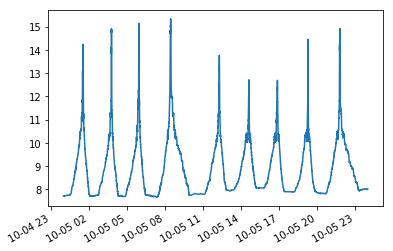

In [20]:
# locally processed
fig, ax = plt.subplots()
ax.plot(time,seawater_temperature)
fig.autofmt_xdate()

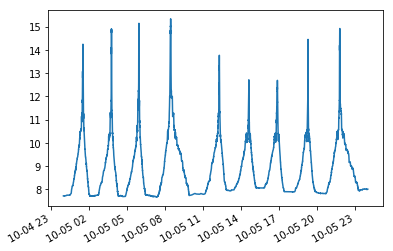

In [21]:
# ooinet processed
fig, ax = plt.subplots()
ax.plot(time_ooinet,seawater_temperature_ooinet)
fig.autofmt_xdate()

This exercise demonstrates the processing chain from raw to processed data product using publicly available code, raw data files and metadata. These data and additional data products could be further assembled into a NetCDF, as is produced by OOINet. This was never necessary for data evaluation purposes and should not prevent scientists from validating the output of OOINet. The "first-in-class" review effort revealed all steps in the data product processing chain, which allowed the Data Team to diagnose the root cause of issues and work with the appropriate team to find a fix.

Stream Engine (uFrame) can be considered an assembly engine that brings together raw data, parsers, algorithms and metadata on demand and in real-time to produce a final NetCDF file (asynchronously) or a real-time JSON data response (synchronously). The Stream Engine code is available on GitHub, but was not used in this exercise, because it is not necessary to recreate the processing pipeline from raw, through parsed and finally processed data.

https://github.com/oceanobservatories/stream_engine